# Dependencies

In [1]:
import os
is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if not is_kaggle:
    !pip install -q scikit-learn pandas numpy nltk matplotlib seaborn
    !pip install -q kaggle

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import random

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Prepare Data

Download the data if not in kaggle

In [3]:
competition_name = "commonlit-evaluate-student-summaries"

if is_kaggle:
    input_path = Path(f"/kaggle/input/{competition_name}")
else:
    input_path = Path.home() / ".kaggle" / "input" / competition_name
    !kaggle competitions download -p {input_path.parent} {competition_name}
    !unzip -o {input_path}.zip -d {input_path}

commonlit-evaluate-student-summaries.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /home/krm/.kaggle/input/commonlit-evaluate-student-summaries.zip
  inflating: /home/krm/.kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv  
  inflating: /home/krm/.kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv  
  inflating: /home/krm/.kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv  
  inflating: /home/krm/.kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv  
  inflating: /home/krm/.kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv  


Load the csv files.

In [4]:
summ_train_df = pd.read_csv(input_path / "summaries_train.csv")
summ_test_df = pd.read_csv(input_path / "summaries_test.csv")
prompts_train_df = pd.read_csv(input_path / "prompts_train.csv")
prompts_test_df = pd.read_csv(input_path / "prompts_test.csv")

Merge the summaries and prompts dataframes for both training and testing

In [5]:
train_df = pd.merge(summ_train_df, prompts_train_df, on="prompt_id")
test_df = pd.merge(summ_test_df, prompts_test_df, on="prompt_id")
train_df

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
...,...,...,...,...,...,...,...,...
7160,fef3e85236e5,39c16e,"It has to be made on a complex storyline, with...",-0.981265,-1.548900,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
7161,ff0f65eecf02,39c16e,Aristotle descirbes an ideal tradgedy as being...,-0.511077,-1.589115,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
7162,ff186473ea0a,39c16e,A tragedy should have a complex plan not a sim...,-0.834946,-0.593749,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
7163,ff5e9e6068da,39c16e,Aristotle believed that the ideal tradegy shou...,-0.157460,-0.165811,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...


## Data Analysis

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   student_id       7165 non-null   object 
 1   prompt_id        7165 non-null   object 
 2   text             7165 non-null   object 
 3   content          7165 non-null   float64
 4   wording          7165 non-null   float64
 5   prompt_question  7165 non-null   object 
 6   prompt_title     7165 non-null   object 
 7   prompt_text      7165 non-null   object 
dtypes: float64(2), object(6)
memory usage: 447.9+ KB


In [7]:
train_df.describe()

,content,wording
count,7165.000000,7165.000000
mean,-0.014853,-0.063072
std,1.043569,1.036048
min,-1.729859,-1.962614
25%,-0.799545,-0.872720
50%,-0.093814,-0.081769
75%,0.499660,0.503833
max,3.900326,4.310693


Plot the correlation between the two scores. Looks like they're positively correlated

<Axes: xlabel='content', ylabel='wording'>

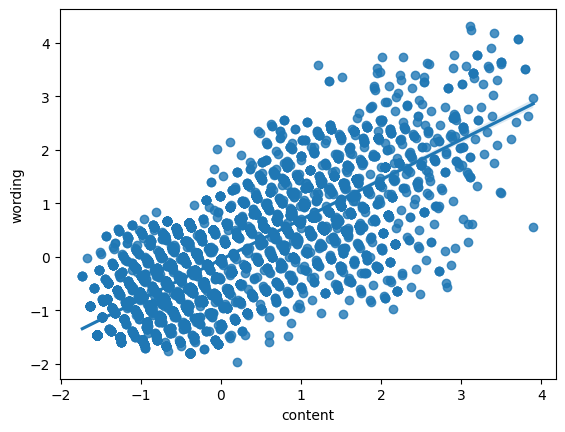

In [8]:
sns.regplot(x=train_df.content, y=train_df.wording)

We can also look at their joint distribution.

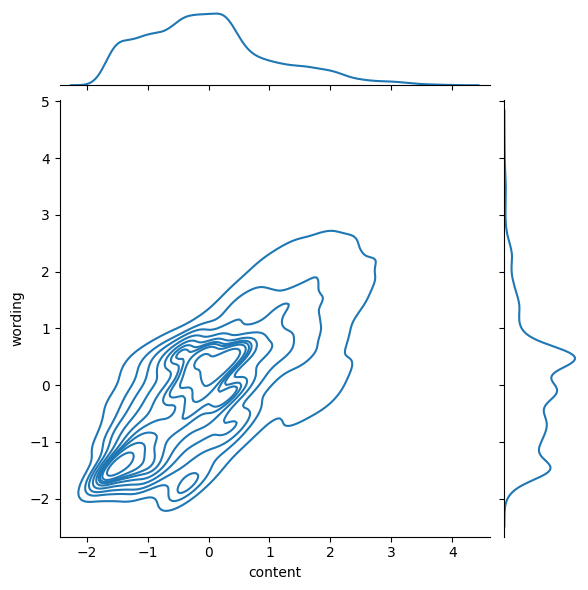

In [9]:
sns.jointplot(x=train_df.content, y=train_df.wording, kind="kde")

Looks like there are 2 discernible clusters

## Feature Engineering

We perform some basic feature engineering on the `text` of the summaries. Inspired by [this notebook][2]

[2]: https://www.kaggle.com/code/sercanyesiloz/commonlit-tf-idf-xgb-baseline#4.-Feature-Engineering

In [10]:
import string
import nltk
import re

if not is_kaggle: nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/krm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Stop words are words which are frequently removed before natural language processing since they do not add significant meaning to the text. We'll make a function to count them.

In [11]:
", ".join([random.choice(stopwords.words('english')) for _ in range(20)])

"d, shan't, by, wasn, on, before, than, which, when, hadn't, yourselves, other, these, had, isn, didn't, after, didn, should've, not"

In [12]:
stopword_set = set(stopwords.words('english'))

def count_stopwords(text):
    return sum([1 for word in text.split() if word.lower() in stopword_set])

sample_text = train_df.text[0]
count_stopwords(sample_text)

25

We also extract some additional features; counts of numbers, punctuation, words, the text length..

In [13]:
punctuation_set = set(string.punctuation)

def count_punctuation(text):
    return sum([1 for char in text if char in punctuation_set])

count_punctuation(sample_text)

3

In [14]:
def count_numbers(text):
    return len(re.findall(r'\d+', text))

count_numbers(sample_text)

0

In [15]:
def add_textual_features(dataframe):
    column_name = "text"
    dataframe[f'{column_name}_word_count'] = dataframe[column_name].apply(lambda text: len(text.split()))
    dataframe[f'{column_name}_length'] = dataframe[column_name].apply(lambda text: len(text))
    dataframe[f'{column_name}_stopword_count'] = dataframe[column_name].apply(lambda text: count_stopwords(text))
    dataframe[f'{column_name}_punctuation_count'] = dataframe[column_name].apply(lambda text: count_punctuation(text))
    dataframe[f'{column_name}_number_count'] = dataframe[column_name].apply(lambda text: count_numbers(text))
    dataframe[f'{column_name}_to_prompt_ratio'] = dataframe.apply(lambda row: len(row.text.split()) / len(row.prompt_text.split()), axis=1)
    
    return dataframe

full_train_df = add_textual_features(train_df)
full_test_df = add_textual_features(test_df)

In [16]:
full_train_df.describe()

,content,wording,text_word_count,text_length,text_stopword_count,text_punctuation_count,text_number_count,text_to_prompt_ratio
count,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000
mean,-0.014853,-0.063072,74.811724,418.776971,36.306769,9.355059,0.378786,0.114185
std,1.043569,1.036048,53.503992,307.833685,25.813092,9.474397,0.937313,0.086843
min,-1.729859,-1.962614,22.000000,114.000000,5.000000,0.000000,0.000000,0.023810
25%,-0.799545,-0.872720,39.000000,216.000000,19.000000,4.000000,0.000000,0.058725
50%,-0.093814,-0.081769,58.000000,320.000000,28.000000,6.000000,0.000000,0.087748
75%,0.499660,0.503833,92.000000,513.000000,45.000000,12.000000,0.000000,0.138182
max,3.900326,4.310693,647.000000,3940.000000,315.000000,162.000000,14.000000,1.176364


In [17]:
full_train_df.describe(include=['O'])

,student_id,prompt_id,text,prompt_question,prompt_title,prompt_text
count,7165,7165,7165,7165,7165,7165
unique,7165,4,7165,4,4,4
top,000e8c3c7ddb,39c16e,The third wave was an experimentto see how peo...,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
freq,1,2057,1,2057,2057,2057


We can see how the numeric features are correlated.

In [18]:
corr = full_train_df.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

,content,wording,text_word_count,text_length,text_stopword_count,text_punctuation_count,text_number_count,text_to_prompt_ratio
content,1.000000,0.751380,0.792626,0.797244,0.778149,0.670398,0.296109,0.770008
wording,0.751380,1.000000,0.536343,0.540138,0.538102,0.396094,0.162928,0.547368
text_word_count,0.792626,0.536343,1.000000,0.994072,0.987230,0.853952,0.384021,0.935513
text_length,0.797244,0.540138,0.994072,1.000000,0.972962,0.870013,0.388909,0.952742
text_stopword_count,0.778149,0.538102,0.987230,0.972962,1.000000,0.806981,0.347115,0.924365
text_punctuation_count,0.670398,0.396094,0.853952,0.870013,0.806981,1.000000,0.444333,0.803479
text_number_count,0.296109,0.162928,0.384021,0.388909,0.347115,0.444333,1.000000,0.358018
text_to_prompt_ratio,0.770008,0.547368,0.935513,0.952742,0.924365,0.803479,0.358018,1.000000


## Training, Validation, Testing sets

We prepare the training and validation sets. The RF baseline model will all features as numbers:

In [19]:
excluded_cols = ["text", "prompt_question", "prompt_title", "prompt_text"]
categorical_cols = ["student_id", "prompt_id"]

def standardize_features(df):
    df = df.drop(columns=excluded_cols)
    for col in categorical_cols:
        df[col] = pd.Categorical(df[col]).codes
    return df

std_train_df = standardize_features(full_train_df)
std_test_df = standardize_features(full_test_df)

In [20]:
std_train_df

,student_id,prompt_id,content,wording,text_word_count,text_length,text_stopword_count,text_punctuation_count,text_number_count,text_to_prompt_ratio
0,0,2,0.205683,0.380538,61,346,25,3,0,0.102349
1,4,2,3.272894,3.219757,203,1225,92,30,3,0.340604
2,14,2,0.205683,0.380538,60,345,27,9,0,0.100671
3,18,2,0.567975,0.969062,76,451,35,10,0,0.127517
4,20,2,-0.910596,-0.081769,27,145,12,2,0,0.045302
...,...,...,...,...,...,...,...,...,...,...
7160,7143,0,-0.981265,-1.548900,33,180,16,1,0,0.054636
7161,7145,0,-0.511077,-1.589115,30,163,15,3,0,0.049669
7162,7146,0,-0.834946,-0.593749,29,150,16,3,0,0.048013
7163,7157,0,-0.157460,-0.165811,49,297,22,4,0,0.081126


For the baseline model, we'll do a simple train test split at random

In [21]:
from sklearn.model_selection import train_test_split
random.seed(42)

model_train_df, model_val_df = train_test_split(std_train_df, test_size=0.2, random_state=42)
model_train_df.shape, model_val_df.shape

((5732, 10), (1433, 10))

# Fit Model

We'll need to models, since we're predicting each of the content and wording scores

In [22]:
y_cols = ["content", "wording"]
x_cols = [c for c in std_train_df.columns if not c in y_cols]
x_cols

def x_y(df):
    return df[x_cols], df[y_cols]

X_train, y_train = x_y(model_train_df)
X_val, y_val = x_y(model_val_df)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((5732, 8), (5732, 2), (1433, 8), (1433, 2))

The competition uses the MCRMSE metric, of which some explanations have been linked to [here][1]

[1]: https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/discussion/424162

It is essentially the mean of the RMSE scores for each of the two dependent variables. So we'll use the RMSE of each of the two models. We'll also experiment with some hyperparameters

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math

m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train.content)
preds = m.predict(X_val)
mean_squared_error(y_val.content, preds)

0.26845991822203397

In [24]:
def get_model_rmse(target, **kwargs):
    m = RandomForestRegressor(n_jobs=-1, **kwargs)
    m.fit(X_train, y_train[target])
    preds = m.predict(X_val)
    rmse = math.sqrt(mean_squared_error(y_val[target], preds))
    return m, rmse

model_kwargs = dict(oob_score=True, n_estimators=300, random_state=42, max_features="sqrt", max_samples=0.3)
content_m, content_rmse = get_model_rmse('content', **model_kwargs)
wording_m, wording_rmse = get_model_rmse('wording', **model_kwargs)

avg_rmse = np.mean([content_rmse, wording_rmse])
avg_rmse, content_m.oob_score_, wording_m.oob_score_

(0.6127014645017901, 0.766074676791251, 0.49876863010581296)

We get an initial score of 0.6 on the validation data

We can also show feature importances.

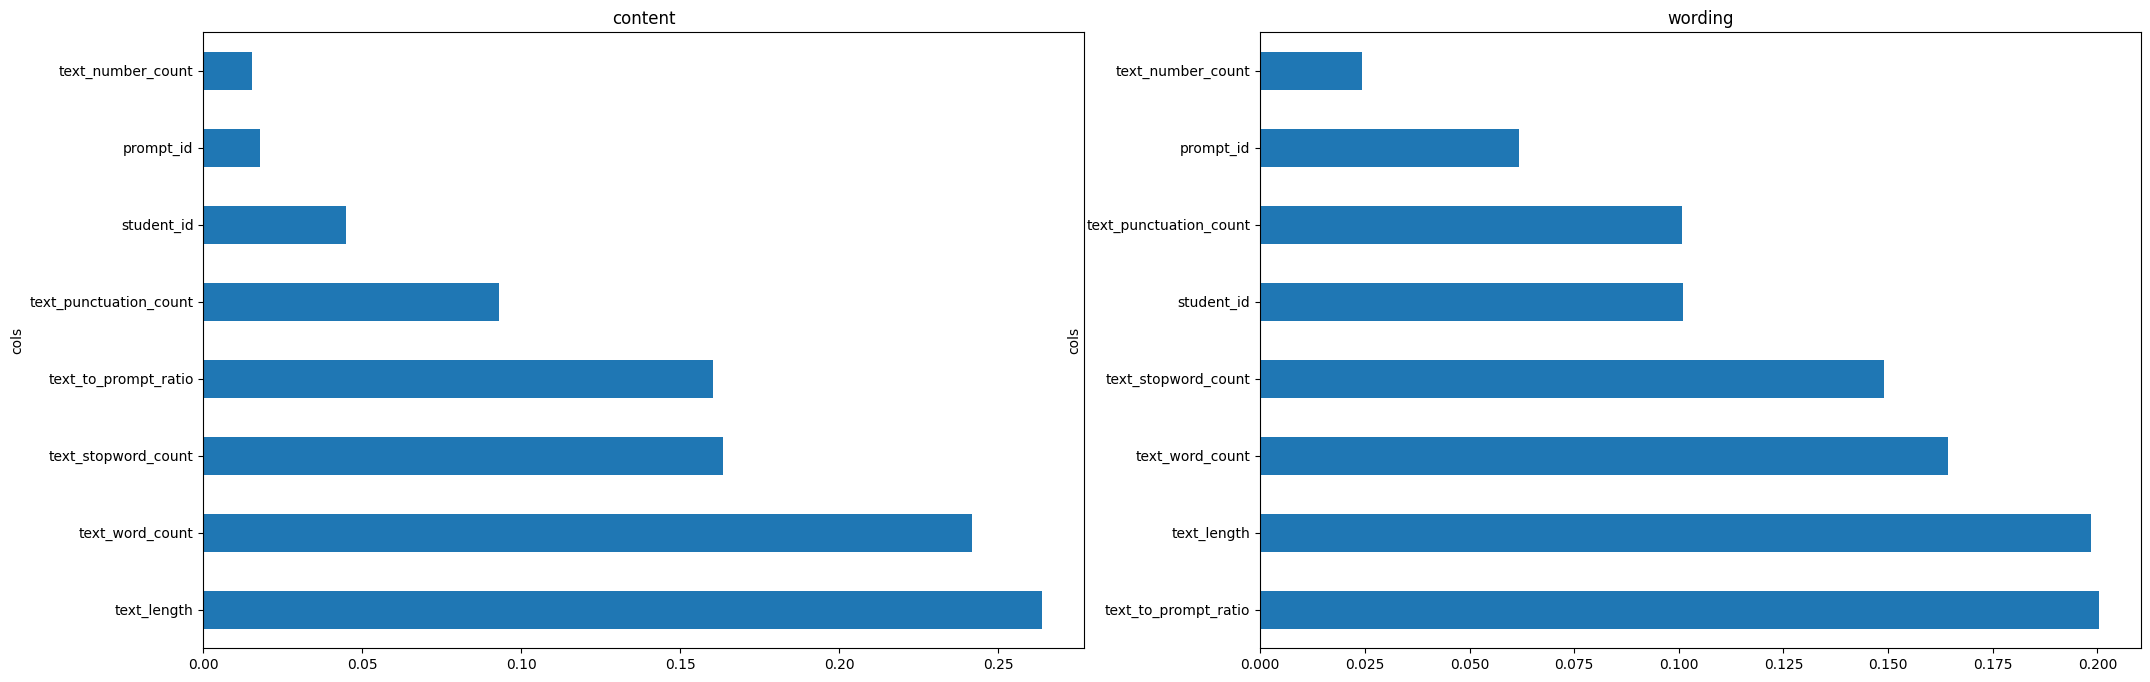

In [25]:
def rf_feature_importance(model, df):
    return pd.DataFrame(
        {'cols': df.columns, 'importance': model.feature_importances_}
    ).sort_values('importance', ascending=False)

def plot_feature_importance(feature_importance, ax=None, title=None):
    feature_importance.plot('cols', 'importance', 'barh', legend=False, ax=ax, title=title)

# todo: use subplots, and titles
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))

plot_feature_importance(rf_feature_importance(content_m, X_train), ax1, title="content")
plot_feature_importance(rf_feature_importance(wording_m, X_train), ax2, title="wording")

Interesting thing to note is for wording, the `text_to_prompt_ratio` has a higher importance.

# Inference

Make predictions on the test set:

In [26]:
X_test = std_test_df[x_cols]

content_preds = content_m.predict(X_test)
wording_preds = wording_m.predict(X_test)

content_preds, wording_preds

(array([-0.74445843, -0.74445843, -0.86242153, -0.86242153]),
 array([-0.66859191, -0.66859191, -0.71937825, -0.71937825]))

# Submission

In [27]:
summ_test_df

,student_id,prompt_id,text
0,000000ffffff,abc123,Example text 1
1,111111eeeeee,def789,Example text 2
2,222222cccccc,abc123,Example text 3
3,333333dddddd,def789,Example text 4


In [28]:
submission_df = summ_test_df.copy()
submission_df['content'] = content_preds
submission_df['wording'] = wording_preds
submission_df = submission_df[['student_id', 'content', 'wording']]
submission_df

,student_id,content,wording
0,000000ffffff,-0.744458,-0.668592
1,111111eeeeee,-0.744458,-0.668592
2,222222cccccc,-0.862422,-0.719378
3,333333dddddd,-0.862422,-0.719378


In [29]:
submission_df.to_csv("submission.csv", index=False)